In [24]:
import osmnx as ox, networkx as nx, time, pandas as pd, numpy as np, matplotlib.cm as cm, matplotlib.pyplot as plt, math
from shapely.geometry import Polygon
ox.config(log_console=True, use_cache=True)
%matplotlib inline

In [2]:
wgs84 = {'init':'epsg:4326'}

# define 3 points in portland
points = {'downtown':(45.518698, -122.679964),
          'laurelhurst':(45.527198, -122.625055),
          'northwest_heights':(45.539635, -122.770915)}

In [3]:
# get a color for each node
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

In [4]:
df = pd.DataFrame()
all_stats = {}
for name, point in points.items():
    
    # create square bbox 354 m in each cardinal direction from point, to make 0.5 sq km bbox
    north, south, east, west = ox.bbox_from_point(point, distance=354)
    top, bottom, right, left = ox.bbox_from_point(point, distance=354, project_utm=True)
    
    # project the bbox to calculate its area in square kilometers - should be approx 0.5 sq km
    bbox_polygon_utm = Polygon([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)])
    area = bbox_polygon_utm.area
    
    # get the driving network and project it
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    G_proj = ox.project_graph(G)
    
    # plot and save the figure
    filename = '{}_network'.format(name)
    fig, ax = ox.plot_graph(G_proj, fig_height=6, fig_width=6, bbox=(top, bottom, right, left),
                            node_color='#336699', node_size=30, node_zorder=2,
                            save=True, filename=filename, show=False)
    
    stats = ox.basic_stats(G, area=area)
    extended_stats = ox.extended_stats(G, connectivity=True, anc=True, ecc=True, bc=True, cc=True)
    for key in extended_stats:
        stats[key] = extended_stats[key]
    stats['area_km'] = area / 1e6 #sq m to sq km
    stats['node_connectivity_avg_undir'] = nx.average_node_connectivity(G.to_undirected())
    
    filename = '{}_betweenness_centrality'.format(name)
    nc = get_node_colors_by_stat(G_proj, stats['betweenness_centrality'])
    fig, ax = ox.plot_graph(G_proj, fig_height=6, fig_width=6, bbox=(top, bottom, right, left),
                            node_color=nc, node_size=50, node_zorder=2,
                            save=True, filename=filename, show=False)
        
    all_stats[name] = stats
    df = df.append(pd.Series(data=stats, name=name))

In [5]:
cols = [col for col in df.columns if not isinstance(df.reset_index().loc[0, col], dict)]
df_display = pd.DataFrame(df[cols])

df_display['pagerank_max_node'] = df_display['pagerank_max_node'].astype(int)
df_display['pagerank_min_node'] = df_display['pagerank_min_node'].astype(int)

def clean_display(value):
    if isinstance(value, float):
        value = round(value, 3)
    return value

df_display = df_display.applymap(clean_display).T
df_display

,downtown,northwest_heights,laurelhurst
area_km,0.505,0.504,0.506
avg_neighbor_degree_avg,1.64,2.75,2.976
avg_weighted_neighbor_degree_avg,0.024,0.03,0.059
betweenness_centrality_avg,0.07,0.137,0.077
center,[40528446],[40618935],[40495960]
circuity_avg,1.001,1.09,1.007
closeness_centrality_avg,0.002,0.002,0.002
clustering_coefficient_avg,0,0,0.108
clustering_coefficient_weighted_avg,0,0,0.023
count_intersections,82,14,55


In [6]:
df_display.to_csv('data/display_table.csv', index=True, encoding='utf-8')

In [7]:
# how much did each network's improve going from directed to undirected?
(df['node_connectivity_avg_undir'] / df['node_connectivity_avg'] - 1) * 100

downtown             116.231555
northwest_heights      0.000000
laurelhurst           18.491290
dtype: float64

If all one-way edges became two-way edges, average node connectivity would increase 116% downtown, 18% in Laurelhurst, and 0% in Northwest Heights.

In [8]:
# what is the max betwenness centrality in each network?
for key in all_stats:
    print(key, max(all_stats[key]['betweenness_centrality'].values()))

downtown 0.14710737896227669
northwest_heights 0.4342105263157895
laurelhurst 0.23869924186087288


In [13]:
# unpack k-counts and k-proportion dicts into individiual keys:values
for place in all_stats:
    for k, count in all_stats[place]['streets_per_node_counts'].items():
        all_stats[place]['int_{}_streets_count'.format(k)] = count
    for k, proportion in all_stats[place]['streets_per_node_proportion'].items():
        all_stats[place]['int_{}_streets_prop'.format(k)] = proportion

In [20]:
all_stats.keys()

dict_keys(['downtown', 'northwest_heights', 'laurelhurst'])

In [22]:
for place in all_stats:
    names.append(place)
    proportion_streets_per_intersection.append(all_stats[place]['streets_per_node_proportion'])

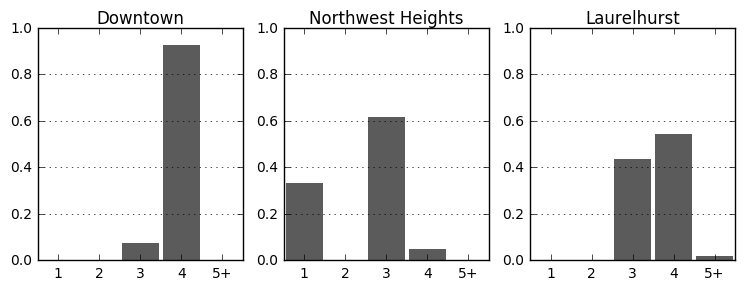

In [38]:
n = 3
cols = 3
rows = 1
max_value = 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 3))
for i, (prop, name) in enumerate(zip(proportion_streets_per_intersection, names)):
    
    row = math.floor(i / cols)
    col = i % cols
    ax = axes[col]
    
    all_others = sum(list(prop.values())[max_value + 1:])
    prop = {key:value for key, value in prop.items() if key <= max_value}
    prop[max_value + 1] = all_others
    lefts = [x - 0.45 for x in prop.keys()]
    
    ax.bar(left=lefts, height=prop.values(), width=0.9, alpha=0.4, color='k', linewidth=0)
    ax.yaxis.grid(True)
    xticklabels = list(range(0, max_value + 1)) + ['{}+'.format(max_value + 1)]
    ax.set_xticklabels(xticklabels)
    
    ax.set_title('{}'.format(name.replace('_', ' ').title()), fontsize=12, y=0.99)
    ax.set_xlim(0.5, max_value + 1.5)
    ax.set_ylim(0, 1)